In [1]:
import pickle

# Load meta dict

with open('../../PNC/MegaMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [2]:
emoid_ts = []
labels = [] # less than or greater than 15

for key in meta:
    if 'emoid' in meta[key] and 'badEmoid' not in meta[key]:
        age = int(meta[key]['meta']['AgeInMonths'])/12
        if age < 15:
            labels.append(0)
        else:
            labels.append(1)
        emoid_ts.append(meta[key]['emoidData'])
        
print(len(labels))
print(len(emoid_ts))

678
678


In [6]:
import numpy as np

nTrain = 600
perm = np.random.permutation(np.arange(len(emoid_ts)))
trainIdx = perm[:nTrain]
testIdx = perm[nTrain:]

with open('../../Work/Explainer/GCN/1/EmoidSplit1.pkl', 'wb') as f:
    pickle.dump({'trainIdx': trainIdx, 'testIdx': testIdx}, f)
    
print('Complete')

Complete


In [7]:
with open('../../Work/Explainer/GCN/1/EmoidSplit1.pkl', 'rb') as f:
    dct = pickle.load(f)
    trainIdx = dct['trainIdx']
    testIdx = dct['testIdx']
    
print(trainIdx.shape)
print(testIdx.shape)

(600,)
(78,)


In [8]:
# Derive the FC

import torch

emoid_ps = [np.corrcoef(ts) for ts in emoid_ts]
emoid_ps_t = torch.from_numpy(np.stack(emoid_ps)).float().cuda()

print(emoid_ps_t.shape)

torch.Size([678, 264, 264])


In [12]:
# Get the adjacency matrix

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

# Cosine similarity
def calcEdges(ps1, ps2):
    nB = ps1.shape[0]
    e = torch.einsum('aij,bij->ab',ps1,ps2)
    F1 = torch.einsum('aij,aij->a',ps1,ps1)**0.5
    F2 = torch.einsum('aij,aij->a',ps2,ps2)**0.5
    e /= F1.unsqueeze(1)
    e /= F2.unsqueeze(1).T
    return normalize(e-torch.eye(nB).float().cuda())

A = calcEdges(emoid_ps_t[trainIdx], emoid_ps_t[trainIdx])

print(A.shape)

torch.Size([600, 600])


In [18]:
# Train the model

import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gc1 = nn.Linear(264*264,100).float().cuda()
        self.gc2 = nn.Linear(100,2).float().cuda()
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, x):
        A = x[0]+torch.eye(x[0].shape[0]).float().cuda()
        z = x[1]
        x = A@z
        x = F.relu(self.gc1(x))
        x = A@x
        x = torch.sigmoid(self.gc2(x))
        return x
    
gcn = GCN()
optim = torch.optim.Adam(gcn.parameters(), lr=5e-6, weight_decay=0.2)

nEpoch = 3000
pPrint = 200

labels_t = torch.LongTensor(labels)[trainIdx].cuda()
feat_t = emoid_ps_t[trainIdx].reshape(-1,264*264)

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gcn([A,feat_t]).squeeze()
    loss = gcn.loss(pred, labels_t)
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')
        
print('Complete')

epoch 0 loss=0.6933020353317261
epoch 200 loss=0.5950138568878174
epoch 400 loss=0.5616796016693115
epoch 600 loss=0.5439354181289673
epoch 800 loss=0.5326303839683533
epoch 1000 loss=0.5246864557266235
epoch 1200 loss=0.5183127522468567
epoch 1400 loss=0.5145112872123718
epoch 1600 loss=0.5120344161987305
epoch 1800 loss=0.5100800395011902
epoch 2000 loss=0.5086767673492432
epoch 2200 loss=0.5074832439422607
epoch 2400 loss=0.5064774751663208
epoch 2600 loss=0.5056054592132568
epoch 2800 loss=0.5040475726127625
epoch 2999 loss=0.5032002329826355
Complete


In [30]:
# Get model accuracy

A = calcEdges(emoid_ps_t, emoid_ps_t)
feat_t = emoid_ps_t.reshape(-1,264*264)
pred = gcn([A,feat_t]).squeeze()
pred = pred[testIdx]
y_t = torch.LongTensor(labels)[testIdx].cuda()
nCorrect = torch.sum(torch.argmax(pred,dim=1) == y_t)
print(f'{nCorrect/testIdx.shape[0]*100}%')

84.61538696289062%


In [268]:
# Explain decision for a node

nSub = emoid_ps_t.shape[0]

class Explainer(nn.Module):
    def __init__(self):
        super(Explainer, self).__init__()
        self.Amask = nn.Parameter(torch.ones(nSub,nSub).float().cuda())
        self.fmask = nn.Parameter(torch.ones(264*264).float().cuda())
        
    def forward(self, x):
        Amask = torch.sigmoid(self.Amask)
        fmask = torch.sigmoid(self.fmask)
        A = x[0]*Amask
        feat = x[1]*fmask.expand(nSub,264*264)
        model = x[2]
        pred = model([A,feat]).squeeze()
        return pred
        
    def loss(self, predNodeLabel, predNodeIdx, pred, A):
        Amask = torch.sigmoid(self.Amask)
        fmask = torch.sigmoid(self.fmask)
        pred_loss = -torch.log(pred[predNodeIdx, predNodeLabel])
        size_loss = torch.sum(Amask)
        feat_size_loss = torch.sum(fmask)
        mask_ent_loss = torch.mean(-Amask*torch.log(Amask) - (1-Amask)*torch.log(1-Amask))
        feat_ent_loss = torch.mean(-fmask*torch.log(fmask) - (1-fmask)*torch.log(1-fmask))
        m_adj = Amask*A
        D = torch.diag(torch.sum(m_adj, dim=0))
        L = D - m_adj
        pred = torch.argmax(pred,dim=1).unsqueeze(1).float()
        lap_loss = pred.T @ L @ pred
        return pred_loss + 1.1e0*size_loss + 5.05e5*mask_ent_loss + 1e-4*feat_size_loss + 5*feat_ent_loss + lap_loss
    
nEpoch = 100
pPrint = 20

exp = Explainer()
optim = torch.optim.Adam(exp.parameters(), lr=1e-1, weight_decay=0)

A = calcEdges(emoid_ps_t, emoid_ps_t)
labels_t = torch.LongTensor(labels).cuda()
feat_t = emoid_ps_t.reshape(-1,264*264)
nodeIdx = testIdx[0]

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = exp([A,feat_t,gcn])
    loss = exp.loss(labels_t[nodeIdx], nodeIdx, pred, A)
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')
        
print('Complete')

epoch 0 loss=tensor([[663805.]], device='cuda:0', grad_fn=<AddBackward0>)
epoch 20 loss=tensor([[430674.7188]], device='cuda:0', grad_fn=<AddBackward0>)
epoch 40 loss=tensor([[104647.8516]], device='cuda:0', grad_fn=<AddBackward0>)
epoch 60 loss=tensor([[36459.4258]], device='cuda:0', grad_fn=<AddBackward0>)
epoch 80 loss=tensor([[20993.3184]], device='cuda:0', grad_fn=<AddBackward0>)
epoch 99 loss=tensor([[15059.2920]], device='cuda:0', grad_fn=<AddBackward0>)
Complete


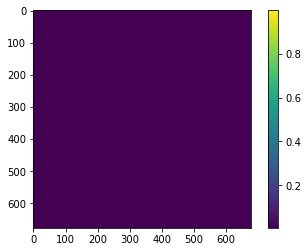

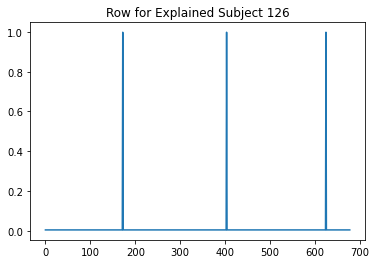

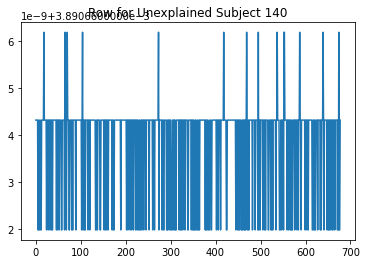

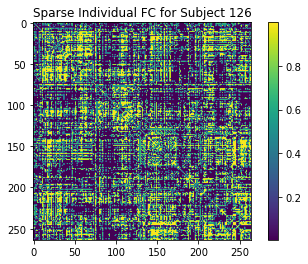

In [269]:
import matplotlib.pyplot as plt

Am = torch.sigmoid(exp.Amask).detach().cpu().numpy()
fm = torch.sigmoid(exp.fmask).reshape(264,264).detach().cpu().numpy()

plt.imshow(Am)
plt.colorbar()
# plt.title('Sparse Subject-Subject Population Graph')
plt.show()

plt.plot(Am[nodeIdx,:])
plt.title(f'Row for Explained Subject {nodeIdx}')
plt.show()

plt.plot(Am[nodeIdx+14,:])
plt.title(f'Row for Unexplained Subject {nodeIdx+14}')
plt.show()

plt.imshow(fm)
plt.colorbar()
plt.title(f'Sparse Individual FC for Subject {nodeIdx}')
plt.show()

In [270]:
pred[nodeIdx]

tensor([0.0021, 0.9933], device='cuda:0', grad_fn=<SelectBackward0>)

In [85]:
labels_t[nodeIdx]

tensor(1, device='cuda:0')

In [129]:
Am[nodeIdx,0:20]

array([0.99958247, 0.999582  , 0.99958235, 0.99958235, 0.9995826 ,
       0.00140318, 0.99958247, 0.99958223, 0.99958235, 0.9995826 ,
       0.99958235, 0.99958223, 0.99958223, 0.99958247, 0.99958247,
       0.9995826 , 0.9995826 , 0.9995826 , 0.00140314, 0.00140308],
      dtype=float32)

In [130]:
Am[nodeIdx+1,0:20]

array([0.99958247, 0.00140346, 0.00140277, 0.00140336, 0.99958247,
       0.99958247, 0.99958247, 0.0014035 , 0.00140355, 0.99958247,
       0.00140254, 0.00140356, 0.00140353, 0.99958247, 0.99958247,
       0.99958247, 0.99958247, 0.99958247, 0.99958247, 0.99958247],
      dtype=float32)

In [273]:
np.where(Am > 0.5)

(array([126, 126, 126]), array([172, 403, 624]))

In [279]:
labels_t[624]

tensor(1, device='cuda:0')

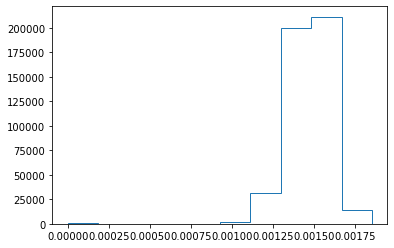

In [289]:
dist = A.detach().cpu().numpy().flatten()

plt.hist(dist, histtype='step')
plt.show()

In [298]:
x,y = np.where(A.detach().cpu().numpy() < 0.00075)
np.where(x != y)

(array([], dtype=int64),)

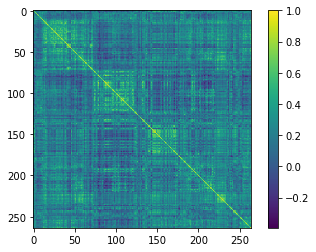

tensor(0.7413, device='cuda:0')

In [294]:
plt.imshow(emoid_ps_t[0].detach().cpu().numpy())
plt.colorbar()
plt.show()

f1 = torch.sum(emoid_ps_t[0]**2)**0.5
f2 = torch.sum(emoid_ps_t[1]**2)**0.5
torch.sum(emoid_ps_t[0]*emoid_ps_t[1])/f1/f2

In [296]:
A[0:3,0:3]

tensor([[-3.5748e-10,  1.5001e-03,  1.5075e-03],
        [ 1.5001e-03, -6.1043e-10,  1.4566e-03],
        [ 1.5075e-03,  1.4566e-03, -2.1864e-10]], device='cuda:0')